# Import Package Yang Dibutuhkan

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Ambil dan Baca File Dataset

In [2]:
df = pd.read_csv("DATASET/dataset rata-rata.csv", sep=';') # membaca dataset dari file CSV dengan pemisah titik koma
df['Tanggal'] = pd.to_datetime(df['Tanggal'], dayfirst=True) # ubah kolom 'Tanggal' menjadi tipe datetime dan mengatur format hari-bulan-tahun
df = df.sort_values('Tanggal') # urutkan data berdasarkan tanggal
df.set_index('Tanggal', inplace=True) # set kolom 'Tanggal' sebagai index

In [3]:
df.head() # menampilkan 5 baris pertama dari dataset

,Harga
Tanggal,
2018-01-02,122150.0
2018-01-03,126450.0
2018-01-04,107850.0
2018-01-05,121550.0
2018-01-08,121150.0


In [4]:
df.tail() # menampilkan 5 baris terakhir dari dataset

,Harga
Tanggal,
2025-05-26,156100.0
2025-05-27,156100.0
2025-05-28,156100.0
2025-05-29,156100.0
2025-05-30,156100.0


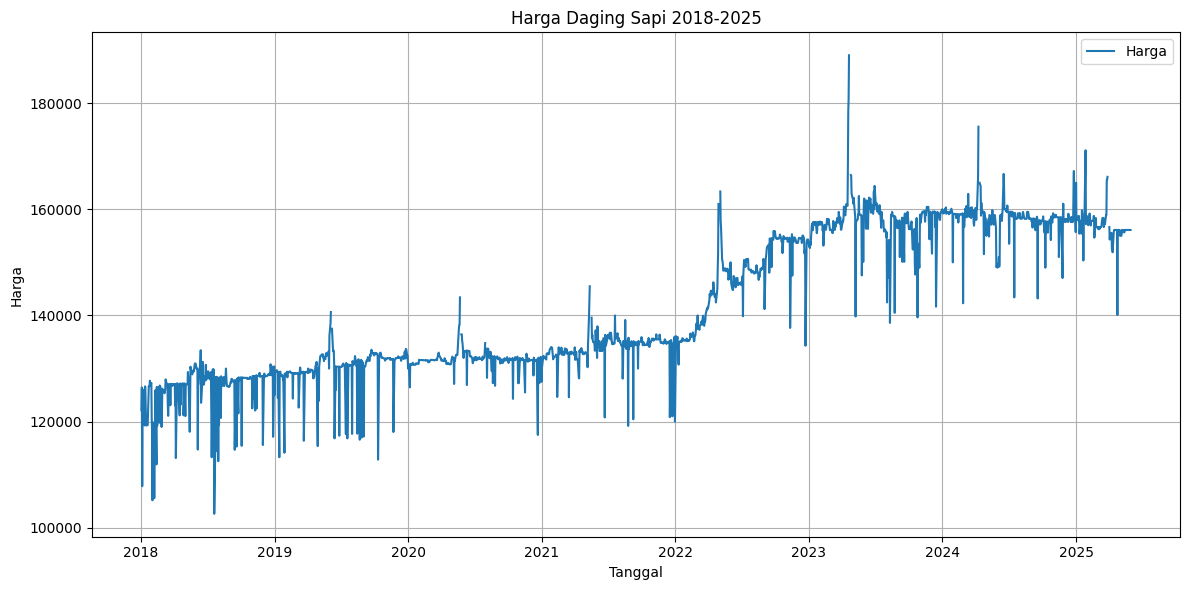

In [5]:
plt.figure(figsize=(12,6)) # plot ukuran grafik
plt.plot(df.index, df['Harga'], label='Harga') # plot harga daging sapi
plt.title('Harga Daging Sapi 2018-2025') # judul grafik
plt.xlabel('Tanggal') # label sumbu x
plt.ylabel('Harga') # label sumbu y
plt.legend() # menampilkan legenda
plt.grid(True) # menampilkan grid pada grafik
plt.tight_layout() # mengatur layout grafik agar lebih rapi
plt.show() # menampilkan grafik harga daging sapi

In [6]:
print(df['Harga'].describe())

count      1908.000000
mean     141551.808176
std       13421.208265
min      102650.000000
25%      131350.000000
50%      135150.000000
75%      156650.000000
max      189000.000000
Name: Harga, dtype: float64


# Preprocessing

Pengecekan Nilai Kosong

In [7]:
print('Jumlah nilai kosong:') # menampilkan jumlah nilai kosong
df.isnull().sum() # menampilkan jumlah nilai kosong pada setiap kolom

Jumlah nilai kosong:


Harga    14
dtype: int64

Pengecekan Nilai Duplikat

In [8]:
duplicate_dates = df.index.duplicated().sum() # menghitung jumlah tanggal duplikat pada index
print(f'Jumlah tanggal duplikat pada index: {duplicate_dates}') # menampilkan jumlah tanggal duplikat pada index

Jumlah tanggal duplikat pada index: 0


Penghapusan Nilai Kosong

In [9]:
df = df.dropna() # menghapus baris yang memiliki nilai kosong

In [10]:
df.isnull().sum() # menampilkan jumlah nilai kosong setelah penghapusan

Harga    0
dtype: int64

Normalisasi data dengan MinMaxScaler

In [11]:
scaler = MinMaxScaler() # inisialisasi MinMaxScaler untuk normalisasi data
scaled_data = scaler.fit_transform(df[['Harga']]) # normalisasi data harga daging sapi

In [12]:
print('Data setelah normalisasi:') # menampilkan data setelah normalisasi
scaled_df = pd.DataFrame(scaled_data, index=df.index, columns=['Harga_Daging_Sapi']) # membuat DataFrame baru dengan data yang sudah dinormalisasi
scaled_df.head() # menampilkan 5 baris pertama dari data yang sudah dinormalisasi   

Data setelah normalisasi:


,Harga_Daging_Sapi
Tanggal,
2018-01-02,0.225825
2018-01-03,0.275622
2018-01-04,0.060220
2018-01-05,0.218877
2018-01-08,0.214244


## Membuat Fitur dan Target Menggunakan Sliding Window

In [13]:
def create_dataset(dataset, time_step=30): # fungsi untuk membuat dataset dengan time step 30
    X, y = [], [] # inisialisasi list untuk fitur (X) dan target (y)
    for i in range(len(dataset) - time_step): # iterasi untuk membuat fitur dan target
        X.append(dataset[i:(i + time_step), 0]) # mengambil data dari indeks i sampai i + time_step
        y.append(dataset[i + time_step, 0]) # target adalah data pada indeks i + time_step
    return np.array(X), np.array(y) # mengembalikan fitur dan target sebagai array numpy
time_step = 30 # mendefinisikan time step untuk dataset
X, y = create_dataset(scaled_data, time_step) # membuat dataset dengan time step 30
X = X.reshape(X.shape[0], X.shape[1], 1) # mengubah bentuk X menjadi 3D array untuk LSTM input

# Membangun Model LSTM

Membagi Rasio Data Latih dan Uji

In [14]:
train_size = int(len(X) * 0.9) # mendefinisikan ukuran data latih sebagai 90% dari total data
X_train, X_test = X[:train_size], X[train_size:] # membagi data menjadi data latih dan data uji
y_train, y_test = y[:train_size], y[train_size:] # membagi target menjadi data latih dan data uji

Membangun Hidden Layer LSTM

In [15]:
model = Sequential() # inisialisasi model Sequential
model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1))) # menambahkan layer LSTM pertama dengan 64 unit dan return_sequences=True
model.add(Dropout(0.2)) # menambahkan layer Dropout untuk mengurangi overfitting
model.add(LSTM(64)) # menambahkan layer LSTM kedua dengan 64 unit
model.add(Dropout(0.2)) # menambahkan layer Dropout kedua
model.add(Dense(1)) # menambahkan layer Dense output dengan 1 unit
optimizer = Adam(learning_rate=0.05) # inisialisasi optimizer Adam dengan learning rate 0.05
model.compile(optimizer=optimizer, loss='mean_squared_error') # mengkompilasi model dengan loss function mean squared error

c:\Users\mfasa\Documents\Ngoding\Deep Learning\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# Training Model

In [16]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=250, batch_size=32, verbose=1) # melatih model dengan data latih dan validasi, selama 250 epoch dengan batch size 32

Epoch 1/250
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 2.3163 - val_loss: 0.0421
Epoch 2/250
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0840 - val_loss: 0.0453
Epoch 3/250
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0270 - val_loss: 0.0197
Epoch 4/250
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0187 - val_loss: 0.0045
Epoch 5/250
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0157 - val_loss: 0.0041
Epoch 6/250
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0128 - val_loss: 0.0120
Epoch 7/250
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0120 - val_loss: 0.0020
Epoch 8/250
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0068 - val_loss: 0.0028
Epoch 9/250
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0050 - val_loss: 0.0054
Epoch 10/250
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 0.0048 - val_loss: 0.0015
Epoch 11/250
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0049 - val_loss: 0.0015
Epoch 12/250
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step

In [17]:
train_predict = model.predict(X_train) # melakukan prediksi pada data latih
test_predict = model.predict(X_test) # melakukan prediksi pada data uji

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


# Visualisasi Hasil Training

In [18]:
train_predict = scaler.inverse_transform(train_predict) # mengembalikan skala prediksi data latih
test_predict = scaler.inverse_transform(test_predict) # mengembalikan skala prediksi data uji
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1)) # mengembalikan skala target data latih
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1)) # mengembalikan skala target data uji

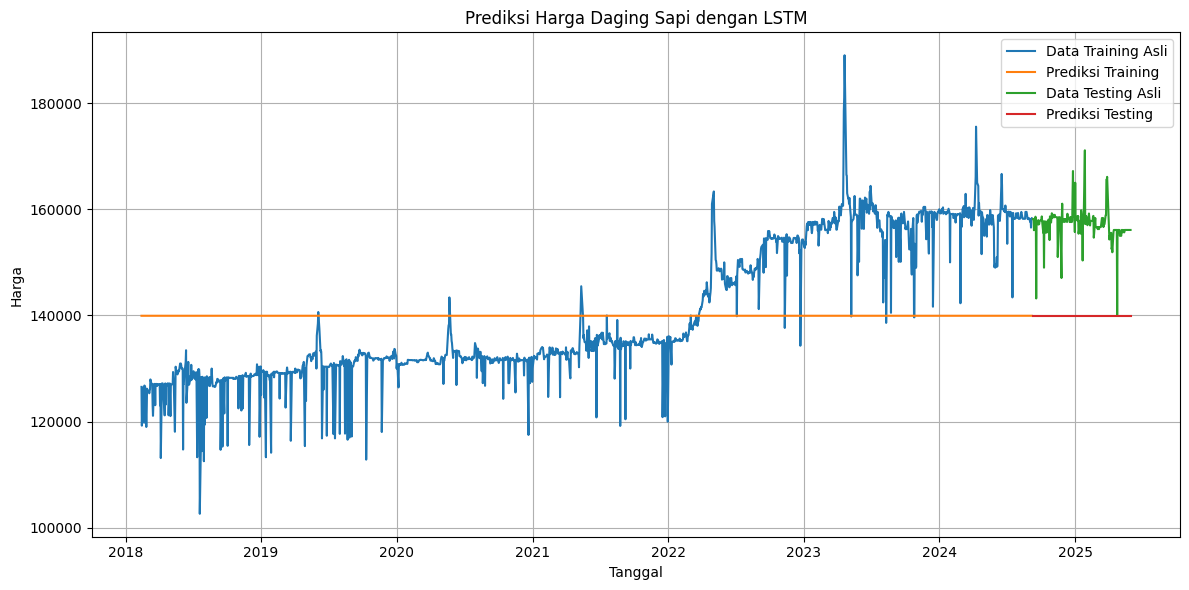

In [19]:
train_dates = df.index[time_step:train_size + time_step] # menagmbil tanggal untuk data latih
test_dates = df.index[train_size + time_step:] # mengambil tanggal untuk data uji

plt.figure(figsize=(12,6)) # plot ukuran grafik
plt.plot(train_dates, y_train_inv, label='Data Training Asli') # plot data asli training
plt.plot(train_dates, train_predict, label='Prediksi Training') # plot prediksi training
plt.plot(test_dates, y_test_inv, label='Data Testing Asli') # plot data asli testing
plt.plot(test_dates, test_predict, label='Prediksi Testing') # plot prediksi testing
plt.legend() # menampilkan legenda
plt.title('Prediksi Harga Daging Sapi dengan LSTM') # judul grafik
plt.xlabel('Tanggal') # label sumbu x
plt.ylabel('Harga') # label sumbu y
plt.grid(True) # menampilkan grid pada grafik
plt.tight_layout() # mengatur layout grafik agar lebih rapi
plt.show() # menampilkan grafik prediksi harga daging sapi

# Evaluasi Model

In [20]:
# Hitung MSE
mse = mean_squared_error(y_test_inv, test_predict) # Hitung Mean Squared Error (MSE)
print(f'Mean Squared Error (MSE): {mse}') # menampilkan MSE

# Hitung RMSE
rmse = np.sqrt(mse) # Hitung Root Mean Squared Error (RMSE)
print(f'Root Mean Squared Error (RMSE): {rmse}') # menampilkan RMSE

# Hitung MAE
mae = mean_absolute_error(y_test_inv, test_predict) # Hitung Mean Absolute Error (MAE)
print(f'Mean Absolute Error (MAE): {mae}') # menampilkan MAE

# Hitung MAPE
mape = np.mean(np.abs((y_test_inv - test_predict) / (y_test_inv + 1e-8))) * 100 # Hitung Mean Absolute Percentage Error (MAPE) dan menghindari pembagian dengan nol
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%') # menampilkan MAPE

Mean Squared Error (MSE): 308973014.66493
Root Mean Squared Error (RMSE): 17577.628243449966
Mean Absolute Error (MAE): 17321.796875
Mean Absolute Percentage Error (MAPE): 10.98%


# Prediksi 90 Hari Kedepan

Prediksi 90 hari ke depan (normalized)

In [21]:
future_steps = 90 # menentukan jumlah langkah prediksi ke depan
last_input = scaled_data[-time_step:].reshape(1, time_step, 1) # mengambil data terakhir untuk prediksi dan mengubah bentuknya menjadi 3D array
future_preds_90_norm = [] # inisialisasi list untuk menyimpan prediksi 90 hari ke depan

for _ in range(future_steps): # loop untuk melakukan prediksi 90 hari ke depan
    pred = model.predict(last_input, verbose=0) # melakukan prediksi dengan model
    future_preds_90_norm.append(pred[0, 0])  # menyimpan prediksi ke dalam list
    last_input = np.append(last_input[:, 1:, :], [[[pred[0, 0]]]], axis=1) # memperbarui input terakhir dengan prediksi baru

Denormalisasi hasil prediksi

In [22]:
future_preds_90_actual = scaler.inverse_transform(np.array(future_preds_90_norm).reshape(-1, 1)).flatten().astype(int) # denormalisasi hasil prediksi dan mengubahnya menjadi integer

Buat DataFrame untuk Tabel

In [23]:
last_date = df.index[-1] # mengambil tanggal terakhir dari data historis
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_steps) # membuat rentang tanggal untuk 90 hari ke depan

# Versi Normalized
df_future_90_norm = pd.DataFrame({ # membuat DataFrame untuk prediksi 90 hari ke depan dengan harga dinormalisasi
    'No': range(1, future_steps + 1),
    'Tanggal': future_dates_90.strftime('%Y-%m-%d'),
    'Prediksi Harga Daging Sapi (Normalized)': np.round(future_preds_90_norm, 6)
})

# Versi DENORMALIZED
df_future_90_actual = pd.DataFrame({ # membuat DataFrame untuk prediksi 90 hari ke depan dengan harga denormalisasi
    'No': range(1, future_steps + 1),
    'Tanggal': future_dates_90.strftime('%Y-%m-%d'),
    'Prediksi Harga Daging Sapi (Rp/Kg)': future_preds_90_actual
})

# Versi untuk plot/gabung (pakai index datetime)
df_future_90_plot = pd.DataFrame({ # membuat DataFrame untuk prediksi 90 hari ke depan dengan index datetime
    'Tanggal': future_dates_90,
    'Prediksi Harga Daging Sapi': future_preds_90_actual
}).set_index('Tanggal')

Gabungkan dengan data historis

In [24]:
df_all = pd.concat([ # menggabungkan DataFrame historis dengan prediksi 90 hari ke depan
    df[['Harga']], # mengambil kolom 'Harga_Daging_Sapi' dari DataFrame historis
    df_future_90_plot.rename(columns={'Prediksi Harga Daging Sapi': 'Harga'}) # mengganti nama kolom untuk konsistensi
])

Tampilkan tabel versi normalisasi dan denormalisasi

In [25]:
print("\nHasil Prediksi 90 Hari Ke Depan (Normalisasi):")
print(df_future_90_norm.to_string(index=False))


Hasil Prediksi 90 Hari Ke Depan (Normalisasi):
 No    Tanggal  Prediksi Harga Daging Sapi (Normalized)
  1 2025-05-31                                 0.431855
  2 2025-06-01                                 0.431855
  3 2025-06-02                                 0.431855
  4 2025-06-03                                 0.431855
  5 2025-06-04                                 0.431855
  6 2025-06-05                                 0.431855
  7 2025-06-06                                 0.431855
  8 2025-06-07                                 0.431855
  9 2025-06-08                                 0.431855
 10 2025-06-09                                 0.431855
 11 2025-06-10                                 0.431855
 12 2025-06-11                                 0.431855
 13 2025-06-12                                 0.431855
 14 2025-06-13                                 0.431855
 15 2025-06-14                                 0.431855
 16 2025-06-15                                 0.431855


In [26]:
print("\nHasil Prediksi 90 Hari Ke Depan (Denormalisasi):")
print(df_future_90_actual.to_string(index=False))


Hasil Prediksi 90 Hari Ke Depan (Denormalisasi):
 No    Tanggal  Prediksi Harga Daging Sapi (Rp/Kg)
  1 2025-05-31                              139940
  2 2025-06-01                              139940
  3 2025-06-02                              139940
  4 2025-06-03                              139940
  5 2025-06-04                              139940
  6 2025-06-05                              139940
  7 2025-06-06                              139940
  8 2025-06-07                              139940
  9 2025-06-08                              139940
 10 2025-06-09                              139940
 11 2025-06-10                              139940
 12 2025-06-11                              139940
 13 2025-06-12                              139940
 14 2025-06-13                              139940
 15 2025-06-14                              139940
 16 2025-06-15                              139940
 17 2025-06-16                              139940
 18 2025-06-17                  

Tampilkan plot harga historis 90 hari + prediksi 90 hari ke depan

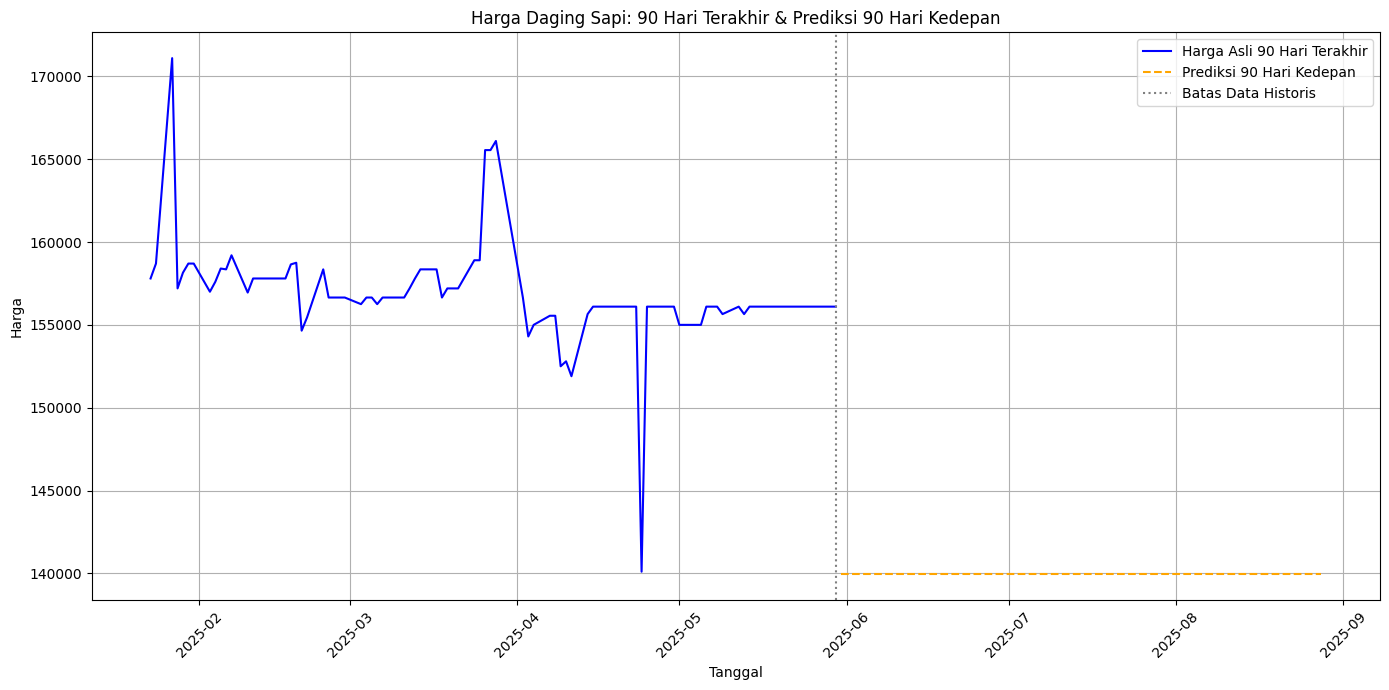

In [27]:
window_hist = 90 # menentukan jumlah hari historis yang akan ditampilkan
last_hist_dates = df.index[-window_hist:] # mengambil tanggal historis terakhir
last_hist_prices = df['Harga'].iloc[-window_hist:] # mengambil harga historis terakhir

future_dates_90_plot = df_future_90_plot.index # mengambil tanggal untuk prediksi 90 hari ke depan
future_prices_90_plot = df_future_90_plot['Prediksi Harga Daging Sapi'] # mengambil harga prediksi 90 hari ke depan

plt.figure(figsize=(14,7)) # plot ukuran grafik
plt.plot(last_hist_dates, last_hist_prices, label=f'Harga Asli {window_hist} Hari Terakhir', color='blue') # plot harga historis terakhir
plt.plot(future_dates_90_plot, future_prices_90_plot, label='Prediksi 90 Hari Kedepan', color='orange', linestyle='--') # plot prediksi 90 hari ke depan
plt.axvline(x=last_hist_dates[-1], color='grey', linestyle=':', label='Batas Data Historis') # garis vertikal untuk batas data historis
plt.title(f'Harga Daging Sapi: {window_hist} Hari Terakhir & Prediksi 90 Hari Kedepan') # judul grafik
plt.xlabel('Tanggal') # label sumbu x
plt.ylabel('Harga') # label sumbu y
plt.xticks(rotation=45) # rotasi label sumbu x agar lebih mudah dibaca
plt.legend() # menampilkan legenda
plt.grid(True) # menampilkan grid pada grafik
plt.tight_layout() # mengatur layout grafik agar lebih rapi
plt.show() # menampilkan grafik harga daging sapi dengan prediksi 90 hari ke depan
